In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import gymnasium as gym
import time
from tqdm import tqdm
import winsound
from torch.distributions import Normal, Categorical
from copy import deepcopy

from FlatOrientation import *
from PPO import *

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

from IPython.display import display, clear_output

sns.set_theme()

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)

%load_ext autoreload
%autoreload 2

## Ориентация КА, PPO

## I. Привидение в точку за 1 секунду

### Обучение

In [6]:
env = FlatOrientation(dt=1e-1, integration='Euler')

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [9]:
agent = PPO(
    state_dim=3,
    action_dim=1, 
    max_action=25, 
    observable_states=[0, 1, 2],
    gamma=1
)

# agent.pi_model = torch.load('models/flat_orientation_pi_140.pth')
# agent.v_model = torch.load('models/flat_orientation_v_140.pth')

In [11]:
train_ppo(
    env, 
    agent, 
    episode_n=10, 
    trajectory_n=100, 
    advantage='default',
)

0: mean reward = -13441.820350955057
1: mean reward = -13338.56813049922
2: mean reward = -12109.72982188858
3: mean reward = -11924.000024537694
4: mean reward = -9798.356228769717
5: mean reward = -12362.602048773508
6: mean reward = -9584.856410574801
7: mean reward = -8850.698342033553
8: mean reward = -9221.28177919137
9: mean reward = -8063.8862622911365


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


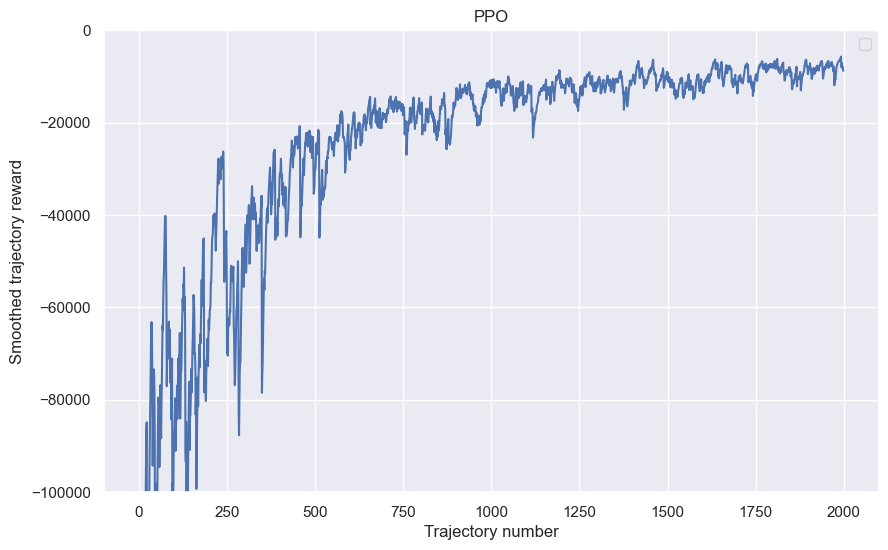

In [14]:
plot_history(agent.history, ylim=[-10**5, 0])

### Валидация

In [15]:
validation_env = FlatOrientation(dt=1e-3)

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [16]:
class AnaliticalAgent(PPO):
    def __init__(self):
        self.discrete_action_space = False
        self.max_action = 1
        self.observable_states = [0, 1, 2]

    def get_action(self, state, prediction=False):
        return [6 * np.pi - 12 * np.pi * state[0]]

In [17]:
validation(validation_env, agent, validation_n=10, prediction=True)

-4043.912347398314

### Управление:

In [18]:
def get_reward(env, agent):
    traj = agent.get_trajectory(env, prediction=True, initial_state=np.array([0, 0, 0]))
    return sum(traj['rewards'])

In [19]:
get_reward(env, agent)

-4222.901856241043

In [20]:
get_reward(env, AnaliticalAgent())

-11860.737871382731

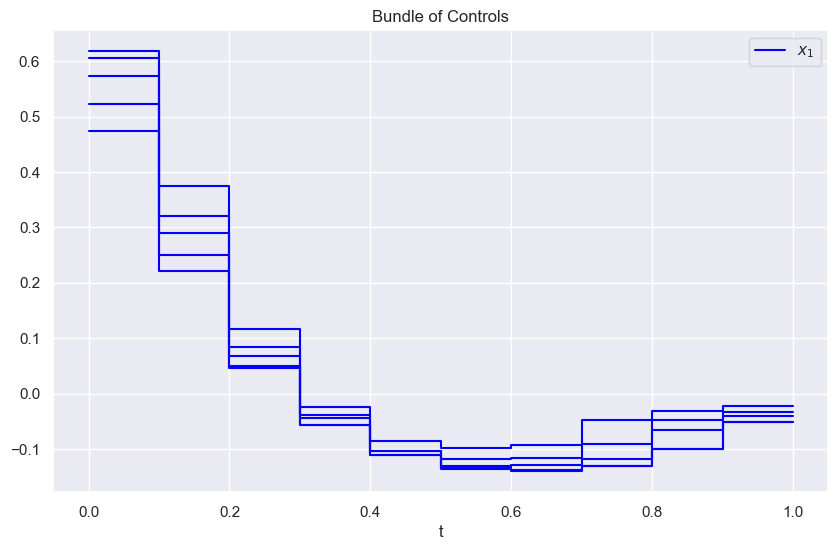

In [21]:
plot_u(env, agent, n=5)

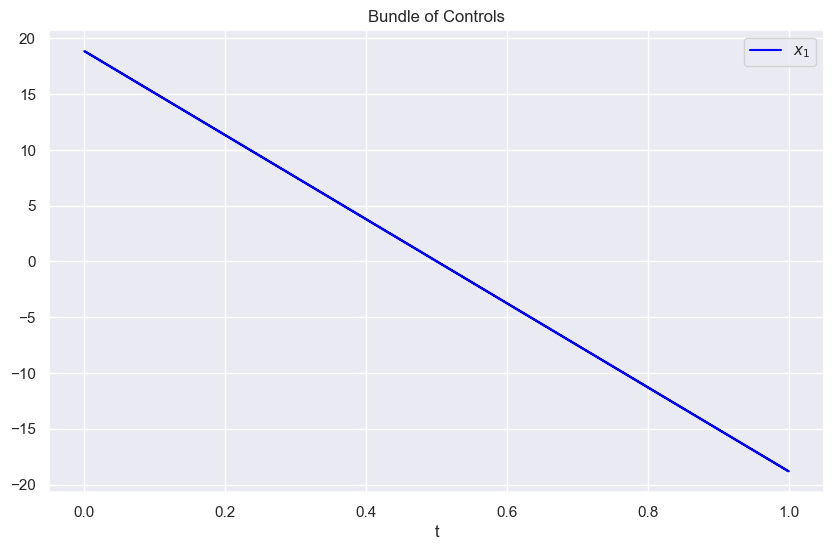

In [22]:
plot_u(validation_env, AnaliticalAgent())

0.009421636368116992 0.01884955592152448


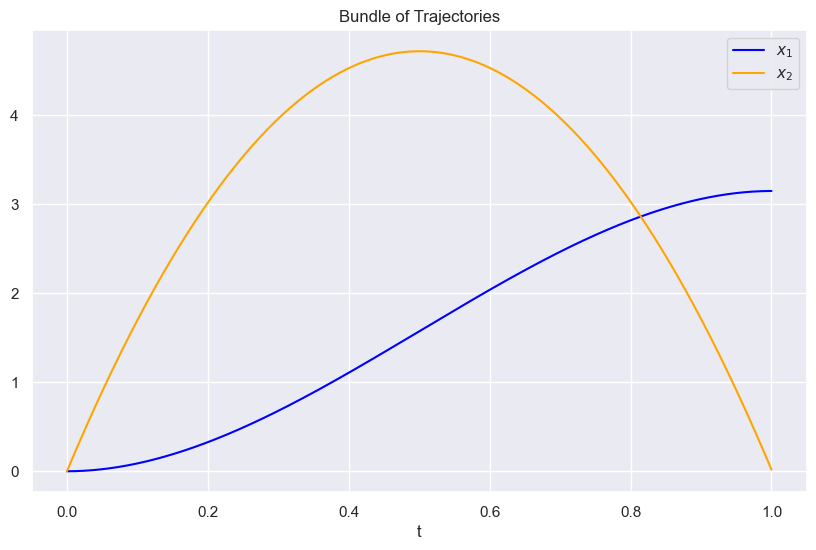

In [23]:
plot_sheaf(validation_env, AnaliticalAgent(), initial_state=[0, 0, 0])

-1.9262060277544426 0.7162185679543743


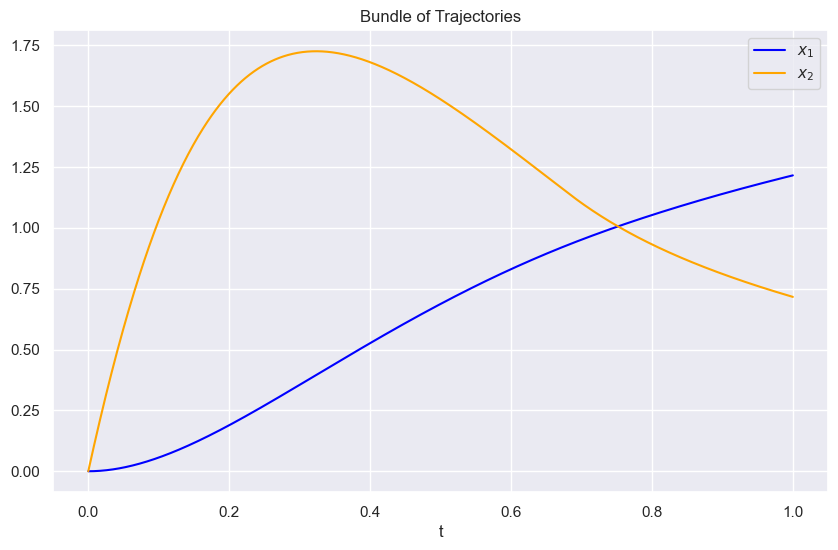

In [24]:
plot_sheaf(validation_env, agent, initial_state=np.array([0, 0, 0]))

-2.046524823961377 0.8503906911423171
-1.7999639645590406 0.5956745616057022
-2.009092437116795 0.8095769712653078
-1.817507493545215 0.6118426457297151
-1.943271523319354 0.7342257014909334


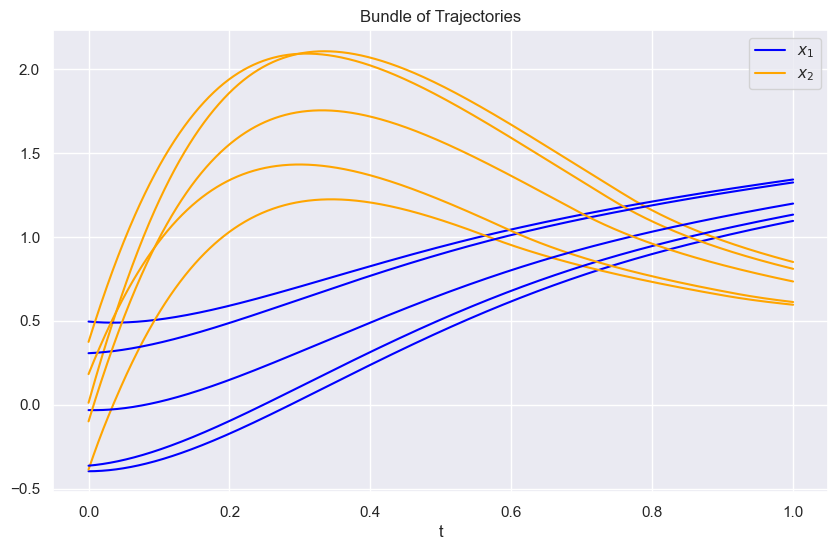

In [25]:
plot_sheaf(validation_env, agent, n=5)

In [174]:
# torch.save(agent.pi_model, 'models/flat_orientation_pi_135.pth')
# torch.save(agent.v_model, 'models/flat_orientation_v_135.pth')

### Testing

In [115]:
dt = 1e-4
euler_env = FlatOrientation(dt=dt, integration='Euler')
rk45_env = FlatOrientation(dt=dt, integration='RK45')

In [116]:
get_reward(euler_env, AnaliticalAgent()), get_reward(rk45_env, AnaliticalAgent())

(-118.43969626688481, -118.43969644452312)

0.0009423521327827089 0.0018849555936547922


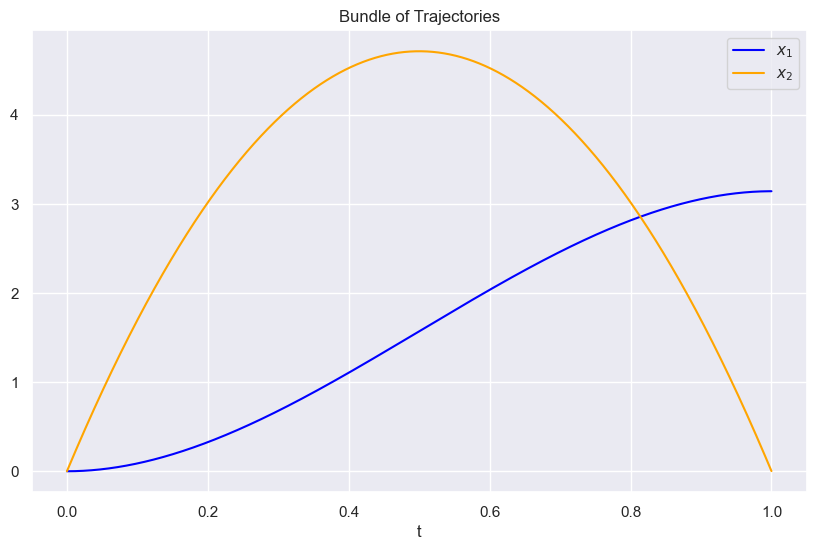

In [117]:
plot_sheaf(euler_env, AnaliticalAgent(), initial_state=[0, 0, 0])

0.0009424463801539495 0.0018849555939234805


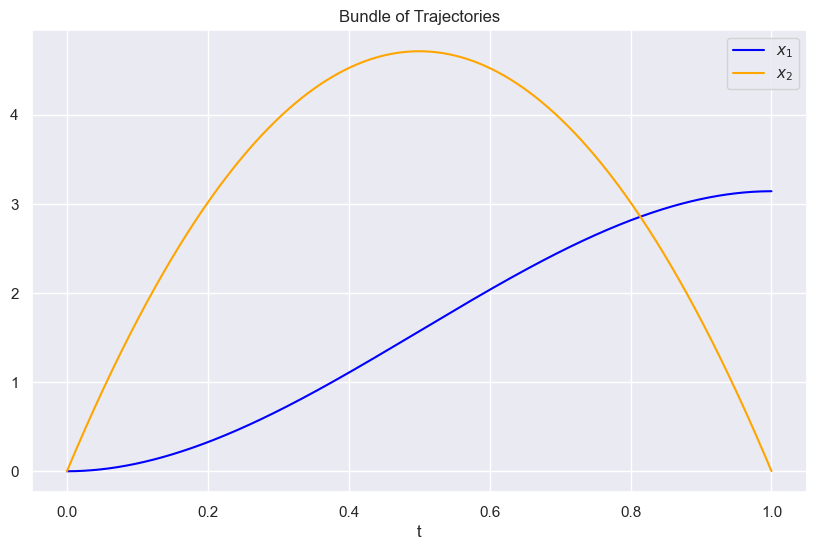

In [118]:
plot_sheaf(rk45_env, AnaliticalAgent(), initial_state=[0, 0, 0])

## II. Стабилизация на отрезке времени 3 секунды.

### Обучение

In [13]:
env = FlatOrientation(
    dt=1e-1, 
    t_end=3,
    R1=1,
    R2=0.1,
    R3=0.001,
    reward_function=stability_reward, 
    integration='Euler'
)

In [14]:
agent = PPO(
    state_dim=2,
    action_dim=1, 
    max_action=25, 
    observable_states=[1, 2],
    gamma=1
)

# agent.pi_model = torch.load('models/flat_orientation_pi_140.pth')
# agent.v_model = torch.load('models/flat_orientation_v_140.pth')

In [17]:
train_ppo(
    env, 
    agent, 
    episode_n=5, 
    trajectory_n=10, 
    advantage='default',
)

0: mean reward = -253.9876595586906


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


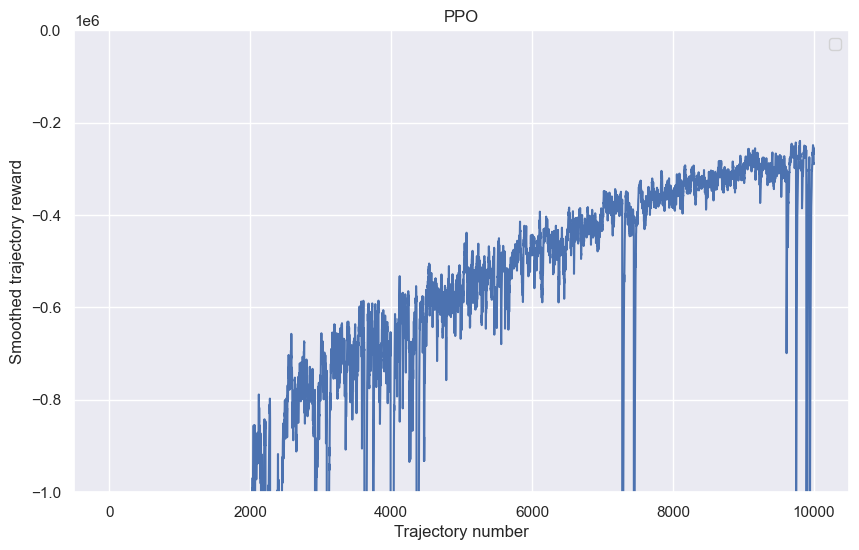

In [30]:
plot_history(agent.history, ylim=[-10**6, 0])

### Валидация

In [31]:
validation_env = FlatOrientation(dt=1e-2, t_end=3, reward_function=stability_reward)

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [32]:
validation(validation_env, agent, validation_n=10, prediction=True)

-1213857.1300222247

### Управление:

In [33]:
traj = agent.get_trajectory(validation_env, prediction=True, initial_state=np.array([0, 0, 0]))

In [34]:
traj['rewards']

[-9919.262966600349,
 -10051.104559898884,
 -10263.561960572344,
 -10548.817426272753,
 -10897.552911242858,
 -11298.043915304526,
 -11734.971902658763,
 -12192.087890092997,
 -12650.735658719945,
 -13095.37170736595,
 -13512.653127102649,
 -13892.213563332727,
 -14226.960551452872,
 -14512.943242651783,
 -14748.91279748143,
 -14935.732515103608,
 -15075.766841160212,
 -15172.340092050812,
 -15226.981523423834,
 -15243.600367100988,
 -15226.543189300046,
 -15177.709088811735,
 -15100.04666015661,
 -14997.533461208963,
 -14873.779914418341,
 -14732.022376900602,
 -14575.135253652295,
 -14405.517283112178,
 -14225.389535261489,
 -14036.723734796897,
 -13841.231215266153,
 -13640.3923695484,
 -13435.483286546365,
 -13227.602015412773,
 -13017.690154588763,
 -12806.553746994692,
 -12594.880199671104,
 -12383.255399284519,
 -12172.175706620988,
 -11962.062256032239,
 -11753.268928401625,
 -11546.093818552255,
 -11340.785361561771,
 -11137.550085732792,
 -10936.558618985464,
 -10737.95002493

In [35]:
def get_reward(env, agent):
    traj = agent.get_trajectory(env, prediction=True, initial_state=np.array([0, 0, 0]))
    return sum(traj['rewards'])

In [36]:
get_reward(env, agent)

-126625.62531166687

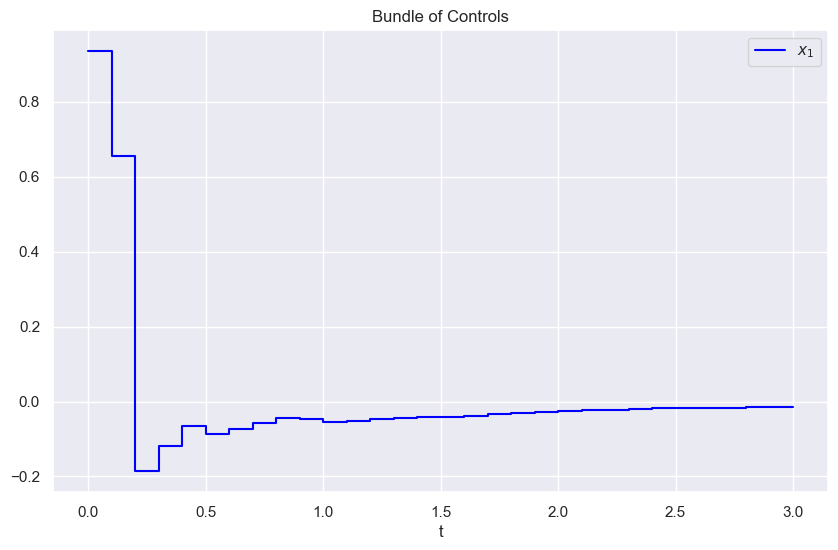

In [37]:
plot_u(env, agent)

0.9135557631677917 0.37306779325008443


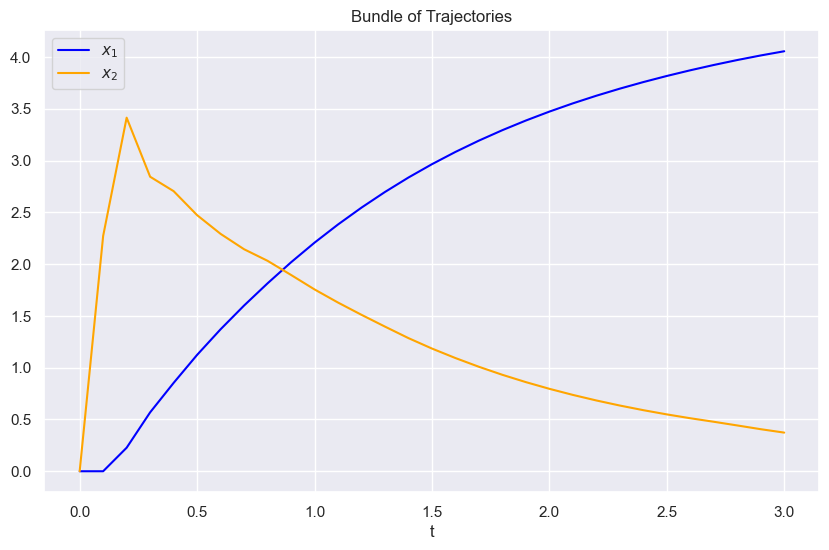

In [38]:
plot_sheaf(env, agent, initial_state=np.array([0, 0, 0]))

In [ ]:
# torch.save(agent.pi_model, 'models/flat_orientation_pi_135.pth')
# torch.save(agent.v_model, 'models/flat_orientation_v_135.pth')